# Voice Recognition

## Audio Modelling

### Dependencies if needed

In [ ]:
!pip install librosa soundfile
!pip install datasets
!pip install evaluate

### Library

In [ ]:
#Library
import pandas as pd
import numpy as np
from datasets import load_dataset, Audio, DatasetDict, concatenate_datasets
import seaborn as sns
import matplotlib.pyplot as plt
import os
import librosa
from IPython.display import Audio
from scipy.signal import medfilt
from dataclasses import dataclass
from typing import Any, Dict, List, Union
from transformers import WhisperTokenizer, WhisperFeatureExtractor, WhisperProcessor, WhisperForConditionalGeneration
#!pip install librosa soundfile (if not installed)

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

!pip install GPUtil
import GPUtil
GPUtil.getAvailable()

Using device: cuda


[0]

In [ ]:
if device:
    print('CUDNN VERSION:', torch.backends.cudnn.version())
    print('Number CUDA Devices:', torch.cuda.device_count())
    print('CUDA Device Name:',torch.cuda.get_device_name(0))
    print('CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

CUDNN VERSION: 90100
Number CUDA Devices: 1
CUDA Device Name: Tesla T4
CUDA Device Total Memory [GB]: 15.835660288


### Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load Dataset
minds_us_data = load_dataset('csv', data_files={
    'train': '/content/drive/MyDrive/ai-portfolio/project3/datasets_split/minds_traindf.csv',
    'test': '/content/drive/MyDrive/ai-portfolio/project3/datasets_split/minds_testdf.csv',
    'validation': '/content/drive/MyDrive/ai-portfolio/project3/datasets_split/minds_valdf.csv'
})

# Print available keys to check what splits are loaded
print("Available splits:", minds_us_data.keys())

# Combine the datasets into one DatasetDict
ds = DatasetDict({
    'train': minds_us_data['train'],
    'test': minds_us_data.get('test'),  # Use .get() to avoid KeyError if 'test' doesn't exist
    'valid': minds_us_data.get('validation')
})

# Check if 'test' split exists before proceeding
if ds['test'] is None:
    print("Warning: 'test' split not found. Please check your dataset.")


Available splits: dict_keys(['train', 'test', 'validation'])


In [ ]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['filepath', 'text_asr', 'text_translated', 'intent'],
        num_rows: 450
    })
    test: Dataset({
        features: ['filepath', 'text_asr', 'text_translated', 'intent'],
        num_rows: 57
    })
    valid: Dataset({
        features: ['filepath', 'text_asr', 'text_translated', 'intent'],
        num_rows: 56
    })
})


In [ ]:
# Defining Load Audio
def load_audio_data(batch, audio_base_path):
    audio_files = [os.path.join(audio_base_path, filepath) for filepath in batch['filepath']]
    audio_data = [librosa.load(file_path, sr=None) for file_path in audio_files]

    # Separate audio data and sample rates
    audio_signals = [data[0] for data in audio_data]
    sample_rates = [data[1] for data in audio_data]

    batch['audio'] = [{'path': file_path, 'array': audio, 'sampling_rate': sr} for file_path, audio, sr in zip(audio_files, audio_signals, sample_rates)]
    return batch


In [ ]:
# Load Audio Path
audio_base_path = "/content/drive/MyDrive/ai-portfolio/project3/datasets/MInDS-14/audio"
ds = ds.map(load_audio_data, fn_kwargs={'audio_base_path': audio_base_path}, batched=True)

print(ds)

DatasetDict({
    train: Dataset({
        features: ['filepath', 'text_asr', 'text_translated', 'intent', 'audio'],
        num_rows: 450
    })
    test: Dataset({
        features: ['filepath', 'text_asr', 'text_translated', 'intent', 'audio'],
        num_rows: 57
    })
    valid: Dataset({
        features: ['filepath', 'text_asr', 'text_translated', 'intent', 'audio'],
        num_rows: 56
    })
})


In [ ]:
def update_audio_paths(batch):
    # Generate full path for each audio file
    batch['audio'] = [
        {'path': os.path.join(audio_base_path, filepath),
         'array': audio['array'],
         'sampling_rate': audio['sampling_rate']}
        for filepath, audio in zip(batch['filepath'], batch['audio'])
    ]
    return batch

# Apply the preprocessing function to the dataset
ds = ds.map(update_audio_paths, batched=True)

### Remove the unused columns

In [ ]:
ds = ds.remove_columns(["text_translated", "intent"])

In [ ]:
minds_fix = ds
print(minds_fix)

DatasetDict({
    train: Dataset({
        features: ['filepath', 'text_asr', 'audio'],
        num_rows: 450
    })
    test: Dataset({
        features: ['filepath', 'text_asr', 'audio'],
        num_rows: 57
    })
    valid: Dataset({
        features: ['filepath', 'text_asr', 'audio'],
        num_rows: 56
    })
})


## Audio Augmentation and Extraction

In [ ]:
# Checking the structure of audio data
ds['train']['audio'][0]

{'array': [0.0,
  0.0,
  0.000244140625,
  -0.000244140625,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.000244140625,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  -0.000244140625,
  0.0,
  0.0,
  0.000244140625,
  -0.000244140625,
  0.0,
  0.0,
  0.0,
  -0.000244140625,
  0.000244140625,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  -0.000244140625,
  -0.000244140625,
  -0.000244140625,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.000244140625,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.000244140625,
  -0.000244140625,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.000244140625,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.000244140625,
  0.0,
  0.000244140625,
  0.0,
  0.0,
  0.0,
  -0.000244140625,
  0.0,
  -0.000244140625,
  0.0,
  0.0,
  0.0,
  0.0,
  0.000244140625,
  -0.000244140625,
  -0.000244140625,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  

In [ ]:
import numpy as np
import librosa
from scipy.signal import medfilt

def spectral_gate(audio, sr, threshold=1e-5):
    """
    Simple spectral gating function to reduce noise.
    """
    # Short-time Fourier Transform
    stft = librosa.stft(audio)
    magnitude, phase = librosa.magphase(stft)

    # Median filter for estimating the noise floor
    noise_floor = medfilt(np.abs(magnitude), kernel_size=3)

    # Suppress below the threshold
    magnitude[magnitude < threshold * noise_floor] = 0

    # Reconstruct the signal
    return librosa.istft(magnitude * phase)

def preprocess_audio_data(batch):
    audio_signals = []
    sample_rates = []
    for audio in batch['audio']:
        # Load audio and apply pre-emphasis

        audio_signal, sr = librosa.load(audio['path'], sr=16000)
        audio_signal = librosa.effects.preemphasis(audio_signal)

        # Normalize audio signal
        audio_signal = librosa.util.normalize(audio_signal)

        # Denoise the audio signal using spectral gating
        audio_signal = spectral_gate(audio_signal, sr)

        audio_signals.append(audio_signal)
        sample_rates.append(sr)

    batch['audio'] = [{'array': signal, 'sampling_rate': sr} for signal, sr in zip(audio_signals, sample_rates)]
    return batch

# Apply the preprocessing function to the dataset
ds = ds.map(preprocess_audio_data, batched=True, num_proc=4)

In [ ]:
def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # compute log-Mel input features from input audio array
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # encode target text to label ids
    batch["labels"] = tokenizer(batch["text_asr"]).input_ids
    return batch

In [ ]:
#Setting up Feature Extraction, Tokenizer, Voice Model, etc.
from transformers import WhisperTokenizer, WhisperFeatureExtractor, WhisperProcessor
MODEL_NAME = "openai/whisper-small"
tokenizer = WhisperTokenizer.from_pretrained(MODEL_NAME, language="english", task="transcribe")
feature_extractor = WhisperFeatureExtractor.from_pretrained(MODEL_NAME, language="english", task="transcribe")
processor = WhisperProcessor.from_pretrained(MODEL_NAME, language="english", task="transcribe")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
ds = ds.map(prepare_dataset, remove_columns=ds.column_names["train"], num_proc=4)

### Setting up Voice Model

In [ ]:
from transformers import WhisperForConditionalGeneration
model = WhisperForConditionalGeneration.from_pretrained(MODEL_NAME).to(device)

In [ ]:
model.generation_config.language = "english"
model.generation_config.task = "transcribe"

In [ ]:

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    decoder_start_token_id: int

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

In [ ]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)

## Defining Metrics and Do Training

In [ ]:
!pip install jiwer

In [ ]:
import evaluate
metric = evaluate.load("wer")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="/content/drive/MyDrive/ai-portfolio/project3/output",
    gradient_accumulation_steps=4,  # increase by 2x for every 2x decrease in batch size
    learning_rate=5.6e-5,
    warmup_steps=4,
    max_steps=61,
    gradient_checkpointing=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    save_steps=8,
    eval_steps=8,
    logging_steps=8,
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    report_to="none"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
)

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
processor.save_pretrained(training_args.output_dir)

[]

In [ ]:
report_to="none"

In [ ]:
torch.cuda.empty_cache()
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...


Step,Training Loss,Validation Loss,Wer
8,0.807700,0.561277,28.224101
16,0.427600,0.548985,23.150106
24,0.163400,0.539813,23.678647
32,0.103700,0.565240,24.630021
40,0.040000,0.597726,23.572939
48,0.012000,0.638431,19.873150
56,0.007300,0.642267,19.661734


You have passed task=transcribe, but also have set `forced_decoder_ids` to [[1, None], [2, 50359]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6

TrainOutput(global_step=61, training_loss=0.2050825156515739, metrics={'train_runtime': 1703.1922, 'train_samples_per_second': 1.146, 'train_steps_per_second': 0.036, 'total_flos': 5.5639265181696e+17, 'train_loss': 0.2050825156515739, 'epoch': 4.280701754385965})

## Making Evaluation and Do Inferencing

### Set Evaluation

In [ ]:
trainer_history = pd.DataFrame(trainer.state.log_history)
trainer_history.groupby('step').first().reset_index()
trainer_history

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_wer,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.8077,7.345908,0.000052,0.561404,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,0.561404,8,0.561277,28.224101,32.1404,1.773,0.249,NaN,NaN,NaN,NaN,NaN
2,0.4276,3.053201,0.000044,1.122807,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,1.122807,16,0.548985,23.150106,35.0088,1.628,0.229,NaN,NaN,NaN,NaN,NaN
4,0.1634,2.800498,0.000036,1.684211,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,1.684211,24,0.539813,23.678647,31.9299,1.785,0.251,NaN,NaN,NaN,NaN,NaN
6,0.1037,1.550972,0.000028,2.245614,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,2.245614,32,0.565240,24.630021,32.5819,1.749,0.246,NaN,NaN,NaN,NaN,NaN
8,0.0400,1.316717,0.000021,2.807018,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,2.807018,40,0.597726,23.572939,35.3498,1.612,0.226,NaN,NaN,NaN,NaN,NaN


### Plotting Evaluation

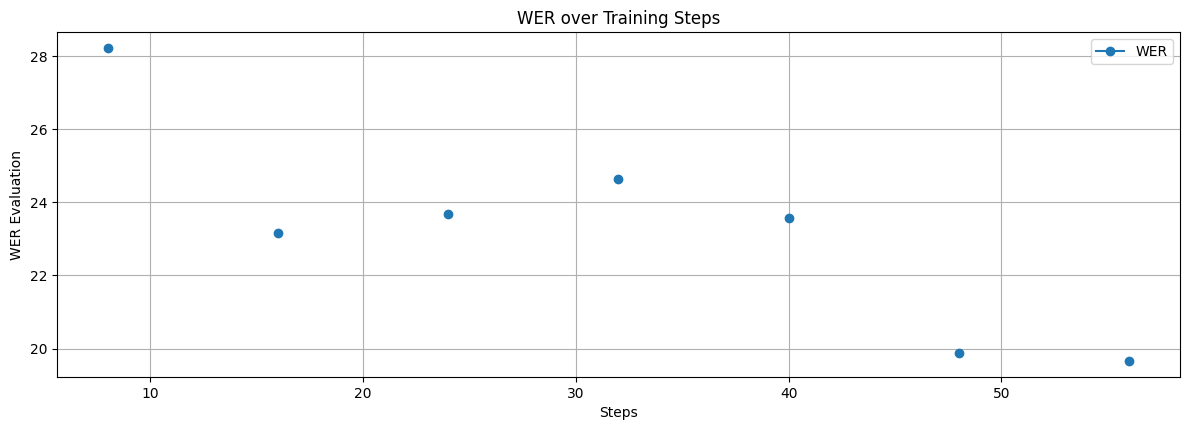

In [ ]:
# Plot WER over training steps
plt.figure(figsize=(12, 8))

# Plot WER
plt.subplot(2, 1, 1)
plt.plot(trainer_history['step'], trainer_history['eval_wer'], marker='o', label='WER')
plt.title("WER over Training Steps")
plt.xlabel("Steps")
plt.ylabel("WER Evaluation")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Setting Inference

In [ ]:
#inferencing
import time
from transformers import WhisperForConditionalGeneration, WhisperProcessor

# Define the path to the model checkpoint (Choose the Lower WER Eval)
model_path = "/content/drive/MyDrive/ai-portfolio/project3/output/checkpoint-56"

try:
    model = WhisperForConditionalGeneration.from_pretrained(model_path)
    processor = WhisperProcessor.from_pretrained(model_path)
    print("Model and processor loaded successfully.")
except OSError as e:
    print(f"Error loading model or processor: {e}")

def transcribe(audio):
    input_features = processor(audio["array"], sampling_rate=audio["sampling_rate"], return_tensors="pt").input_features.to("cpu")

    forced_decoder_ids = processor.get_decoder_prompt_ids(language="de", task="transcribe")

    # Generate predictions and ensure the model's computations are on the correct device
    with torch.no_grad():
        predicted_ids = model.generate(input_features, forced_decoder_ids=forced_decoder_ids)

    # Decode the predictions into text
    transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)
    return transcription[0]


Model and processor loaded successfully.


In [ ]:
from datasets import Audio

minds_fix = minds_fix.cast_column("audio", Audio(sampling_rate=16_000))

### Inferencing

In [ ]:
# Run inference on five samples
for i in range(5):
    sample = minds_fix["test"][i]

    start_time = time.time()
    transcription = transcribe(sample["audio"])
    end_time = time.time()

    inference_time = end_time - start_time

    print(f"Sample {i+1}:")
    print(f"Reference: {sample['text_asr']}")
    print(f"Prediction: {transcription}")
    print(f"Inference time: {inference_time:.4f} seconds")
    print()

# Calculate overall WER for these five samples
wer = metric.compute(predictions=[transcribe(minds_fix["test"][i]["audio"]) for i in range(5)],
                     references=[minds_fix["test"][i]["text_asr"] for i in range(5)])
print(f"WER for 5 samples: {wer}")

Sample 1:
Reference: my card isn't working
Prediction: my card isn't working
Inference time: 5.2733 seconds

Sample 2:
Reference: question but one of my recent transactions
Prediction: question about one of my recent transactions
Inference time: 6.2613 seconds

Sample 3:
Reference: use the app and it is literally not working it's not showing my transactions for Sunday I'm trying to get you a bill and also check the status of a text that needs to be cleared and the app keeps closing it keeps crashing and it's not showing anything on my end
Prediction: hi I'm trying to use the app and it is literally not working it's not showing my transactions from Sunday I'm trying to pay a bill and also check the status of a check that needs to be cleared and the app keeps closing it keeps crashing and it's not showing anything on my end
Inference time: 9.6166 seconds

Sample 4:
Reference: deposit money into my account how can I do that
Prediction: I'd like to deposit some money into my account
Infere